# Libraries

In [2]:
import tarfile
import itertools
import gensim
from nltk.tokenize import RegexpTokenizer
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from os import listdir
from os.path import isfile, join
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re

# Dataset

In [3]:
# Training dataset
alt_1_dirpath_train    = './data/train/1'
alt_2_dirpath_train    = './data/train/2'
alt_3_dirpath_train    = './data/train/3'
alt_4_dirpath_train    = './data/train/4'
alt_5_dirpath_train    = './data/train/5'
alt_6_dirpath_train    = './data/train/6'
alt_7_dirpath_train    = './data/train/7'
alt_8_dirpath_train    = './data/train/8'
alt_9_dirpath_train    = './data/train/9'
alt_10_dirpath_train   = './data/train/10'
dir_paths_train = [
alt_1_dirpath_train, 
alt_2_dirpath_train ,
alt_3_dirpath_train ,
alt_4_dirpath_train ,
alt_5_dirpath_train ,
alt_6_dirpath_train ,
alt_7_dirpath_train ,
alt_8_dirpath_train ,
alt_9_dirpath_train ,
alt_10_dirpath_train
]


# Utility functions

In [4]:
STOPWORDS =['vide']
def remove_extra_whitespace(string):
    string = re.sub(r'\s+', ' ', string)
    string = re.sub(r'[^\u0600-\u06FF]', ' ', string)
    return re.sub(r"\s{2,}", " ", string).strip()
def process_message(message): 
    
    """
    purpose: Given an input message, the function returns a processed version 
             of the message.
    input: 
    message: A string
    
    output:
    A list of tokens(words) with the following processing done on wach token:
           1) The top and bottom blocks are removed 
           2) Lower the case of the doc
           3) Tokenize the doc
           4) Remove stopwords
           5) Stem the words
    """
    
    # skip email headers (first block) and footer (last block)
    #blocks = message.split('\n')
    #content = '\n\n'.join(blocks[1:-1])
    content =remove_extra_whitespace(message)
    return [t_ for t_ in content.split()]
    #return [p_stemmer.stem(t_) for t_ in tokenize(content.lower()) if not t_ in STOPWORDS]


def iter_Docs(dir_path):
    print("Here in file: ",dir_path)
    
    """
    purpose: given a directory, this generator:
             1) finds a valid file in the directory
             2) extracts the document in the file,
             3) calls process_message to process the document content
             4) yields the processed document as list of tokens as returned by process_message
    input:
    dir_path: directory name to look for document files
    
    output:
    List of tokens as returned by process_message for a document. 
    The output is yielded with each yield returning doc for a single file in dir_path. 
    """
    
    for file_name in listdir(dir_path):
        if isfile(join(dir_path, file_name)):
            with open(join(dir_path, file_name), 'r',encoding='utf8') as f_:
                yield process_message(f_.read())

def get_num_of_topics():
    return 10

# Create data streams

In [5]:
# Chain the training/test data streams for each news group to create a single training/test stream 
def getTrainingDataStream():
    stream_train = itertools.chain( iter_Docs(alt_1_dirpath_train), 
                                    iter_Docs(alt_2_dirpath_train), 
                                    iter_Docs(alt_3_dirpath_train), 
                                    iter_Docs(alt_4_dirpath_train), 
                                    iter_Docs(alt_5_dirpath_train), 
                                    iter_Docs(alt_6_dirpath_train), 
                                    iter_Docs(alt_7_dirpath_train), 
                                    iter_Docs(alt_8_dirpath_train), 
                                    iter_Docs(alt_9_dirpath_train), 
                                    iter_Docs(alt_10_dirpath_train))
    return stream_train

def getTestDataStream():
    stream_test = itertools.chain(  iter_Docs(alt_1_dirpath_test), 
                                    iter_Docs(alt_2_dirpath_test), 
                                    iter_Docs(alt_3_dirpath_test), 
                                    iter_Docs(alt_4_dirpath_test), 
                                    iter_Docs(alt_5_dirpath_test), 
                                    iter_Docs(alt_6_dirpath_test), 
                                    iter_Docs(alt_7_dirpath_test), 
                                    iter_Docs(alt_8_dirpath_test), 
                                    iter_Docs(alt_9_dirpath_test), 
                                    iter_Docs(alt_10_dirpath_test))
    return stream_test

# Create vocab dictionary

In [6]:
"""
id2word_Docs: Dictionary of the entire training vocabulary
                    with key being an id to get the word in the vocabulary.
                    The dictionary also has the statistics of the words in the vacabulary. 
"""

id2word_Docs = gensim.corpora.dictionary.Dictionary(getTrainingDataStream())

# Remove all words which appear in less than 10 documents and in more than 10% of the documents.
id2word_Docs.filter_extremes(no_below=10, no_above=0.1)

Here in file:  ./data/train/1
Here in file:  ./data/train/2
Here in file:  ./data/train/3
Here in file:  ./data/train/4
Here in file:  ./data/train/5
Here in file:  ./data/train/6
Here in file:  ./data/train/7
Here in file:  ./data/train/8
Here in file:  ./data/train/9
Here in file:  ./data/train/10


# A class for getting bag of words per document

In [7]:
class NewsDocsCorpus(object):
    def __init__(self, dir_path_list, dictionary, num_docs=None):
        self.dir_path_list = dir_path_list
        self.dictionary = dictionary
        self.num_docs = num_docs
    def __iter__(self):
        for dir_path in self.dir_path_list:
            for tokens in itertools.islice(iter_Docs(dir_path), self.num_docs):
                yield self.dictionary.doc2bow(tokens)
    def __len__(self):
        return self.num_docs

In [8]:
"""
Create a generator which will yield a bag of words 
for each document in all the files belonging to every directory in dir_paths_train.
"""
corpus_train = NewsDocsCorpus(dir_paths_train, id2word_Docs)

# Train LDA model

In [19]:
"""
Train the LDA model.
The number of topics is chosen to be three as we want the model to be able to catagorize three distinct news groups.
"""
lda_model =gensim.models.ldamulticore.LdaMulticore(corpus_train, 
                                   num_topics=get_num_of_topics(), 
                                   id2word=id2word_Docs, 
                                   passes=5)

Here in file:  ./data/train/1
Here in file:  ./data/train/2
Here in file:  ./data/train/3
Here in file:  ./data/train/4
Here in file:  ./data/train/5
Here in file:  ./data/train/6
Here in file:  ./data/train/7
Here in file:  ./data/train/8
Here in file:  ./data/train/9
Here in file:  ./data/train/10
Here in file:  ./data/train/1
Here in file:  ./data/train/2
Here in file:  ./data/train/3
Here in file:  ./data/train/4
Here in file:  ./data/train/5
Here in file:  ./data/train/6
Here in file:  ./data/train/7
Here in file:  ./data/train/8
Here in file:  ./data/train/9
Here in file:  ./data/train/10
Here in file:  ./data/train/1
Here in file:  ./data/train/2
Here in file:  ./data/train/3
Here in file:  ./data/train/4
Here in file:  ./data/train/5
Here in file:  ./data/train/6
Here in file:  ./data/train/7
Here in file:  ./data/train/8
Here in file:  ./data/train/9
Here in file:  ./data/train/10
Here in file:  ./data/train/1
Here in file:  ./data/train/2
Here in file:  ./data/train/3
Here in

In [10]:

"""
Display all the topics and the 5 most relevant words in each topic
"""
lda_model.show_topics(-1, num_words=6)

[(0,
  '0.002*"الاتحاد" + 0.002*"القدم" + 0.002*"المنتخب" + 0.002*"اللاعبين" + 0.002*"الرياضية" + 0.001*"لكرة"'),
 (1,
  '0.012*"فى" + 0.007*"القانون" + 0.006*"مادة" + 0.003*"يجوز" + 0.003*"اللجنة" + 0.003*"الشعبية"'),
 (2,
  '0.003*"قراءة" + 0.003*"المزيد" + 0.003*"البنوك" + 0.003*"البنك" + 0.003*"الاقتصاد" + 0.003*"الاقتصادية"'),
 (3,
  '0.005*"ـ" + 0.004*"لسنة" + 0.003*"م" + 0.003*"الفضاء" + 0.002*"قانون" + 0.002*"الفلك"'),
 (4,
  '0.015*"قصة" + 0.012*"الطفل" + 0.008*"الاجابة" + 0.008*"القراءات" + 0.007*"الاطفال" + 0.004*"استشارات"'),
 (5,
  '0.004*"ابن" + 0.003*"رسول" + 0.003*"فقال" + 0.003*"مِنْ" + 0.003*"أبي" + 0.003*"النبي"'),
 (6,
  '0.007*"بنو" + 0.005*"الحكام" + 0.004*"م" + 0.004*"أسماء" + 0.003*"نقل" + 0.003*"أمراء"'),
 (7,
  '0.011*"الطبية" + 0.010*"قاعة" + 0.008*"العيادة" + 0.007*"شهية" + 0.007*"أكلات" + 0.006*"كوب"'),
 (8,
  '0.006*"نقطة" + 0.005*"فريق" + 0.004*"المباراة" + 0.004*"المركز" + 0.004*"كأس" + 0.004*"نقطة،"'),
 (9,
  '0.008*"الداعية" + 0.007*"دعوية" + 0.006*"مخ

# Test the model

In [11]:
# Test dataset
alt_1_dirpath_test    = './data/test/1'
alt_2_dirpath_test    = './data/test/2'
alt_3_dirpath_test    = './data/test/3'
alt_4_dirpath_test    = './data/test/4'
alt_5_dirpath_test    = './data/test/5'
alt_6_dirpath_test    = './data/test/6'
alt_7_dirpath_test    = './data/test/7'
alt_8_dirpath_test    = './data/test/8'
alt_9_dirpath_test    = './data/test/9'
alt_10_dirpath_test   = './data/test/10'
dir_paths_test = [
alt_1_dirpath_test, 
alt_2_dirpath_test ,
alt_3_dirpath_test ,
alt_4_dirpath_test ,
alt_5_dirpath_test ,
alt_6_dirpath_test ,
alt_7_dirpath_test ,
alt_8_dirpath_test ,
alt_9_dirpath_test ,
alt_10_dirpath_test
]

# Utility function to get topic-document probabilities

In [13]:
def get_topic_probabilities(dir_path, num_docs=None):
    """
    purpose: for num_docs documents in dir_path, return the topic-document probabilities 
                    T1    T2    T3                        
             doc1 [[p_11, p_12, p_13],
             doc2  [p_21, p_22, p_23], 
                    ....
                    ....
         num_docs  [p_num_docsT1, p_num_docsT2, p_num_docsT3]]
    input:
       dir_path: directory path for the files whose topic-document probability we want to find 
       num_docs: number of documents whose topic-document probability we want to find
    output:
       return the topic-document probabilities
    """
    probability = []
    for c_ in itertools.islice(NewsDocsCorpus([dir_path], id2word_Docs, num_docs), num_docs):
        current_prob = [0] * get_num_of_topics()
        for topic, prob in lda_model.get_document_topics(c_):
            current_prob[topic] = prob  
        probability.append(current_prob)
        #print(probability)
    return probability

In [14]:
# Get the topic-document probabilities
alt_1_prob_test = get_topic_probabilities(alt_1_dirpath_test)
alt_2_prob_test = get_topic_probabilities(alt_2_dirpath_test)
alt_3_prob_test = get_topic_probabilities(alt_3_dirpath_test)
alt_4_prob_test = get_topic_probabilities(alt_4_dirpath_test)
alt_5_prob_test = get_topic_probabilities(alt_5_dirpath_test)
alt_6_prob_test = get_topic_probabilities(alt_6_dirpath_test)
alt_7_prob_test = get_topic_probabilities(alt_7_dirpath_test)
alt_8_prob_test = get_topic_probabilities(alt_8_dirpath_test)
alt_9_prob_test = get_topic_probabilities(alt_9_dirpath_test)
alt_10_prob_test= get_topic_probabilities(alt_10_dirpath_test)

Here in file:  ./data/test/1
Here in file:  ./data/test/2
Here in file:  ./data/test/3
Here in file:  ./data/test/4
Here in file:  ./data/test/5
Here in file:  ./data/test/6
Here in file:  ./data/test/7
Here in file:  ./data/test/8
Here in file:  ./data/test/9
Here in file:  ./data/test/10


# Plot the topic-document probabilities

In [15]:
def plot_probabilities(probabilities, col='red', topics=(0,1), legend=''):
    plt.scatter([p_[0] for p_ in probabilities], [p_[1] for p_ in probabilities], color=col,  label=legend)
import pylab 
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 10))

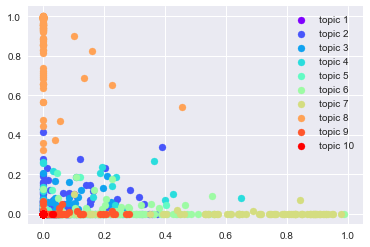

In [18]:
plot_probabilities(alt_1_prob_test, col=colors[0], legend='topic 1')
plot_probabilities(alt_2_prob_test, col=colors[1], legend='topic 2')
plot_probabilities(alt_3_prob_test, col=colors[2], legend='topic 3')
plot_probabilities(alt_4_prob_test, col=colors[3], legend='topic 4')
plot_probabilities(alt_5_prob_test, col=colors[4], legend='topic 5')
plot_probabilities(alt_6_prob_test, col=colors[5], legend='topic 6')
plot_probabilities(alt_7_prob_test, col=colors[6], legend='topic 7')
plot_probabilities(alt_8_prob_test, col=colors[7], legend='topic 8')
plot_probabilities(alt_9_prob_test, col=colors[8], legend='topic 9')
plot_probabilities(alt_10_prob_test, col=colors[9], legend='topic 10')
pylab.ylim([-0.05,1.05])
pylab.xlim([-0.05,1.05])
plt.legend(loc='upper right')
plt.show()